In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import warnings; warnings.simplefilter('ignore')
from csv import reader

In [3]:
'''
Get list of edges from csv file
'''
#file = 'dolphin.csv'
file = 'dolphin.csv'
#file = 'karate.csv'
nodes = []
edge_list = []
with open(file, 'r') as read_obj:
  csv_reader = reader(read_obj)
  count=0
  for row in csv_reader:
    if count!=0:
      xx, yy = row
      x = int(xx) - 1
      y = int(yy) - 1
      edge_list.append((int(x),int(y)))
      if x not in nodes:
        nodes.append(x)
      if y not in nodes:
        nodes.append(y)
    count+=1;

In [4]:
'''
Create Graph from list of  edges
'''

G = nx.Graph()
G.add_edges_from(edge_list)
len(G)

62

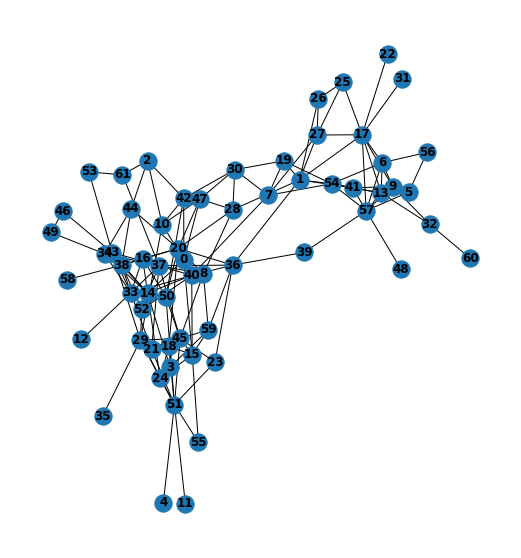

In [5]:
'''
Plot Original Graph
'''
plt.figure(figsize = (20,10))
plt.subplot(122)
nx.draw(G, with_labels=True, font_weight='bold')

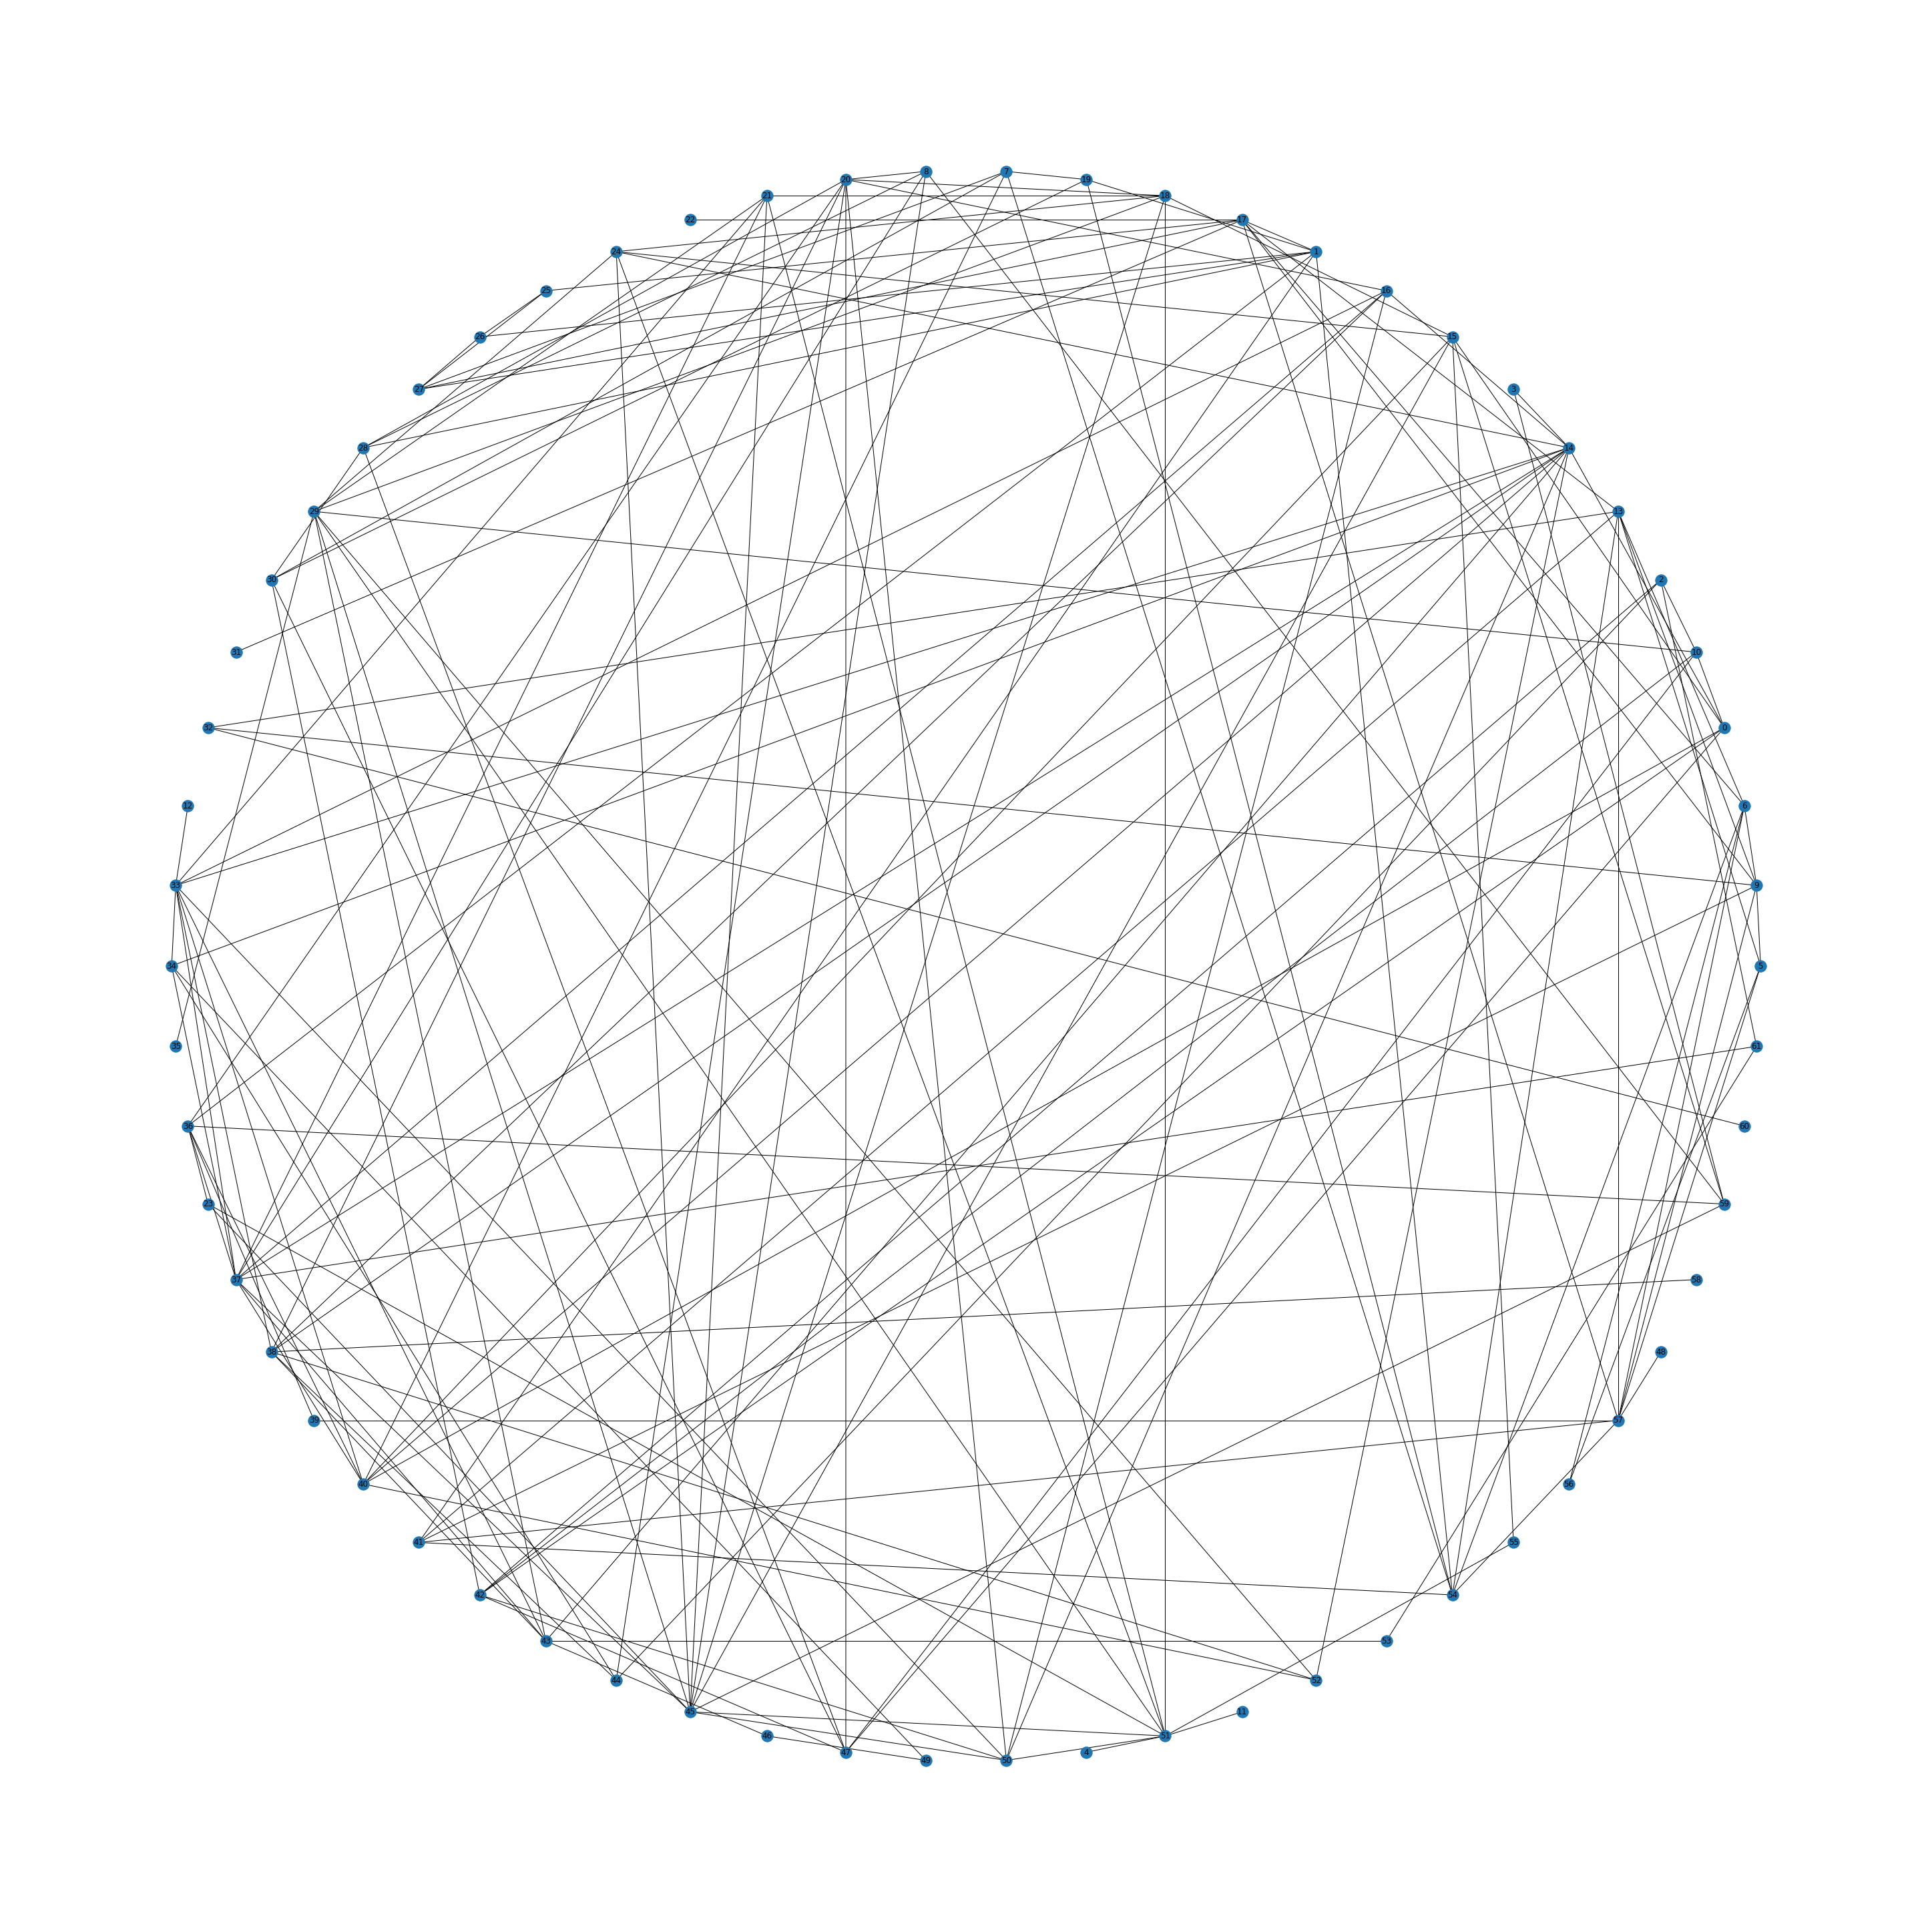

In [6]:
'''
Plot Circular Graph
'''

plt.figure(figsize=(40,40))
nx.draw_circular(G, with_labels=True)

In [7]:
'''
Get adjacency from graph
'''

Adj_matrix = nx.adjacency_matrix(G).todense().tolist()

In [8]:
'''
Parameters for the simulation
'''

ntimes = 10
lamda = 0.9
mu = 0.8

In [9]:
'''
Simulation of the Spreading process with a single node infected
'''

def run_simulation(G, times, Prob_R, Prob_S, Prob_I):
  temp_Prob_R, temp_Prob_S, temp_Prob_I=Prob_R, Prob_S, Prob_I
  for t in range(1, times+1):
    #calculate Prob_S for every node
    for node in nodes:
      Prob_S[node] = temp_Prob_S[node]
      mult = 1
      for n in nodes:
        mult *= (1 - lamda * Adj_matrix[n][node] * temp_Prob_I[n])
      Prob_S[node] *=mult
    #calculate Prob_I for every node
    for n in nodes:
      Prob_I[node] = temp_Prob_S[node]
      mult=1
      for n in nodes:
        mult *= (lamda * Adj_matrix[n][node] * temp_Prob_I[n])
      Prob_I[node] *= (1 - mult)
      Prob_I[node] += (1 - mu) * temp_Prob_I[node]
    #calculate Prob_R for every node
    for n in nodes:
      Prob_R[node] = mu * temp_Prob_I[node] + temp_Prob_R[node]
    temp_Prob_S, temp_Prob_I, temp_Prob_R = Prob_S, Prob_I, Prob_R
  return temp_Prob_S, temp_Prob_I, temp_Prob_R

In [10]:
'''
Infect every node and fill the probability matrix
'''

nodes =  list(G.nodes())
Prob_matrix = [[0 for i in range(len(nodes))] for j in range(len(nodes))]

for node in nodes:
  Prob_R = [0 for _ in range(len(nodes))]
  Prob_S = [mu for _ in range(len(nodes))]
  Prob_I = [0 for _ in range(len(nodes))]

  Prob_I[node] = 1

  Prob_S, Prob_I, Prob_R = run_simulation(G, ntimes, Prob_R, Prob_S, Prob_I)

  for n in nodes:
    Prob_matrix[n][node] = Prob_R[n]

In [11]:
'''
Calculate the partition matrix from the probability matrix
'''

Part_matrix = [[0 for i in range(len(nodes))] for j in range(len(nodes))]
for i in range(len(nodes)):
  for j in range(len(nodes)):
    if i!=j:
      Part_matrix[i][j] = Prob_matrix[i][j]
    else:
      x = 0
      for jj in range(len(nodes)):
        if jj !=i:
          x += Prob_matrix[i][jj]
      Part_matrix[i][j] = x / (len(nodes)-1)

In [17]:
means = [0 for _ in range(len(nodes))]
sds = [1 for _ in range(len(nodes))]

In [18]:
'''
Calculate Pearson Correlation matrix from partition matrix
'''
from __future__ import division

Pear_cor= [[0 for i in range (len(nodes))] for j in range(len(nodes))]
for i in range(len(nodes)):
  for j in range(len(nodes)):
    x=0
    for k in range(len(nodes)):
      x += (Part_matrix[i][k]-means[i])*(Part_matrix[j][k]-means[j])
    x /= (len(nodes)*sds[i] * sds[j])
#     print(len(nodes))
#     print(sds[i])
#     print(sds[j])
    Pear_cor[i][j] = x


In [19]:
'''
Calculate distance matrix from pearson correlation matrix
'''

Distance_matrix = [[0 for i in range(len(nodes))] for j in range(len(nodes))]
for i in range(len(nodes)):
  for j in range(len(nodes)):
    Distance_matrix[i][j]= 1-Pear_cor[i][j]

In [20]:
'''
Perform clustering based on the distance matrix
'''

cluster = AgglomerativeClustering(n_clusters=6, affinity='precomputed', linkage='single')
cluster.fit(Distance_matrix)

AgglomerativeClustering(affinity='precomputed', linkage='single', n_clusters=6)

In [21]:
colors = cluster.labels_
colors

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 3, 2, 1], dtype=int64)

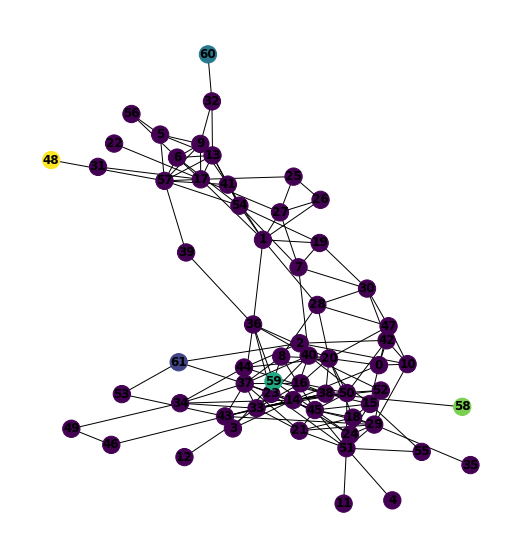

In [22]:
'''
Graph after clustering
'''

plt.figure(figsize=(20,10))
plt.subplot(122)
nx.draw(G, with_labels=True, font_weight='bold', node_color=colors)

In [23]:
data = []

for i in range(len(colors)):
  data.append([i, colors[i]])

df= pd.DataFrame(data, columns=['Node', 'Cluster'])

In [24]:
df

,Node,Cluster
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
57,57,5
58,58,4
59,59,3
60,60,2


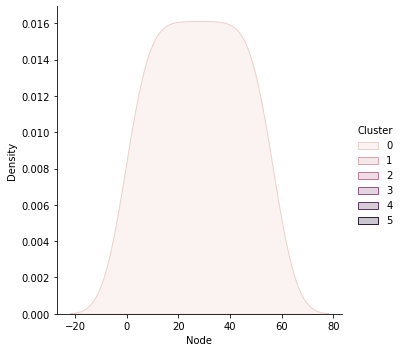

In [25]:
''' Density Plot for different clusters'''
sns.displot(df, x="Node", hue="Cluster", kind="kde", fill=True)

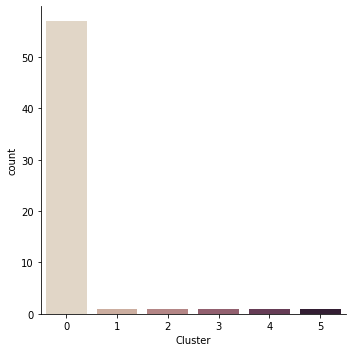

In [26]:
'''
How many nodes in each cluster
'''
sns.catplot(x="Cluster", kind="count", palette="ch:.25", data=df)

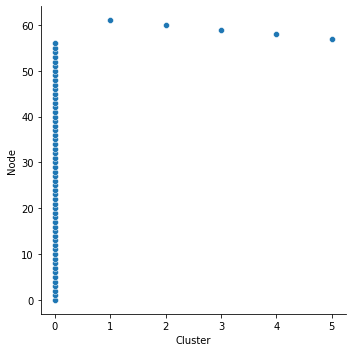

In [27]:
'''
Which cluster contains which nodes
'''
sns.relplot(data=df, x="Cluster", y="Node")